In [288]:
import openai
import os
import requests
import json
import pandas as pd
import numpy as np
import re

In [ ]:
# API configuration
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [169]:
# import preprocessed combined_df
feature_df = pd.read_csv('combined_df_sentiment_2023_06_20.csv')
feature_df

,favourites,retweets,followers,source,label,preprocessed,length_preprocessed,sentiment_BERT,sentiment_RoBERTa
0,50.0,20.0,691748.0,official,-1,The drive-through coronavirus testing site in ...,157,4,1
1,58.0,25.0,12269236.0,official,-1,"""4⃣ and WHO are exploring how the EIB could s...",224,5,1
2,555.0,236.0,12269233.0,official,-1,Media briefing on COVID19 with,32,4,1
3,0.0,3251.0,512848.0,official,-1,"RT : The new NHSCOVID19app, now available in E...",125,5,1
4,NaN,NaN,NaN,competition,1,Dr. Yan presented evidence Covid 19...,190,1,1
...,...,...,...,...,...,...,...,...,...
28604,1.0,0.0,2509.0,truth_seeker,1,Omicron is genetically distant enough from i...,290,4,1
28605,123.0,15.0,691756.0,official,-1,UPDATE on COVIDー19 testing in the UK:\n\nToday...,203,2,1
28606,39.0,33.0,691757.0,official,-1,The pandemic is affecting us all. \n\nIf you a...,244,5,1
28607,129.0,51.0,12269355.0,official,-1,The interim guideline on the use of dexamethas...,168,4,1


In [ ]:
sublist = feature_df[100:111]['preprocessed']
sublist

## Interestingness


#### Label Prompt

In [161]:
labels = "Very interesting, interesting, Moderately interesting, Slightly interesting, Not intersting at all"

system_prompt = """ You are an expert at evaluating the interestingness of tweets. """

key_elements = """ And given these key elements:
1) Relevance: Does the tweet present information or perspectives that are highly pertinent, valuable, or useful to the readers?
2) Information Gap: Does the tweet reveal information that could create a sense of curiosity or an information gap in the readers' knowledge?
3) Novelty: Does the tweet present new, unexpected information or perspectives Does the tweet offer a unique perspective or use unique language or phrasing that could pique the readers' interest?
4) Comprehensibility: Is the tweet comprehensible enough that the reader can grasp its meaning and value with reasonable cognitive effort?
5) Emotional Content: Does the tweet elicit strong emotional responses, such as excitement, humor, shock, controversy, or other feelings that can trigger interest?"""

task_description_labeling = f"""Your job is to correctly label the provided input example into one of the following categories: {labels} 
Carefully read the text of the tweet, paying close attention to details. Then, assign the tweet label based on above key elements.
Before you answer, think step by step. You will first return the label for the given example and then provide a brief reasoning for your choice"""

#### Scoring Prompt

In [162]:
system_prompt = " You are an expert at evaluating the interestingness of tweets. "

baseline = """ And given these key elements:
1) Relevance: Does the tweet present information or perspectives that are highly pertinent, valuable, or useful to the readers?
2) Information Gap: Does the tweet reveal information that could create a sense of curiosity or an information gap in the readers' knowledge?
3) Novelty: Does the tweet present new, unexpected information or perspectives Does the tweet offer a unique perspective or use unique language or phrasing that could pique the readers' interest?
4) Comprehensibility: Is the tweet comprehensible enough that the reader can grasp its meaning and value with reasonable cognitive effort?
5) Emotional Content: Does the tweet elicit strong emotional responses, such as excitement, humor, shock, controversy, or other feelings that can trigger interest?"""

task_description_scoring = """ Carefully read the text of the tweet, paying close attention to details. Provide an interestingness score for the tweet based on above key elements.
The score should be an integer between 1 and 5, where 1 indicates not interesting and 5 very interesting. 
Before you answer, think step by step. Please first provide the score first, then give a brief reasoning. """


### Function Definition


In [160]:
# Define data
results = {
    'tweet': [],
    'score': [],
    'rationale': []
}


In [121]:
for tweet in sublist: 
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {OPENAI_API_KEY}"
    }

    content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description_scoring
 

    data = {
        "model": "gpt-3.5-turbo",
        "messages": [{"role": "user", "content": f"{content}"}],
        "max_tokens": 512,
        "temperature": 0.5
    }


    try: 
        response = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, data=json.dumps(data))
        answer = response.json()['choices'][0]['message']['content']
        results["tweet"].append(tweet)
        results["score"].append(answer.split(":")[1].split("\n")[0].strip())
        results["rationale"].append(answer)
        print(response.json())
    except json.JSONDecodeError:
        print("Couldn't decode the response as JSON") 



{'id': 'chatcmpl-7Tq9bRvFuouqeVpu9xOjHnNQUAYvE', 'object': 'chat.completion', 'created': 1687346347, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Label: Moderately interesting\n\nReasoning: The tweet presents information that is relevant to the current situation surrounding COVID-19, and suggests that new ways of delivering and receiving healthcare may be necessary. This could create a sense of curiosity or information gap for readers who are interested in learning more about potential changes in healthcare delivery. However, the tweet does not present any particularly novel or unique perspectives, and the language used is fairly straightforward and comprehensible. Additionally, while the topic of COVID-19 can elicit strong emotional responses, the tweet itself does not contain any particularly emotional content. Overall, the tweet is moderately interesting.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 303, 'completion

In [122]:
# Create DataFrame
results_df = pd.DataFrame(results)

# Print DataFrame
print(results_df)

                                                tweet                   score  \
0   RT : COVID19 is not going away any time soon. ...  Moderately interesting   
1   Responding to our weekly surveillance report, ...  Moderately interesting   
2   Washing your hands more often remains vitally ...  Moderately interesting   
3   A3: The  Association of Central California dev...  Moderately interesting   
4   "This is very substantial, but to ensure that ...  Moderately interesting   
5   A new saliva test for COVID19 is being trialed...  Moderately interesting   
6   If you participate in contact tracing for COVI...  Moderately interesting   
7                    Blame CHYNA for this lab manu...    Slightly interesting   
8   FBI has arrested a US professor who has manufa...  Not interesting at all   
9   Local hipster keeps telling everyone he was on...  Moderately interesting   
10  CDC has accepted the Advisory Committee on Imm...  Moderately interesting   

                           

In [108]:
# Create DataFrame
results_df = pd.DataFrame(results)

# Print DataFrame
print(results_df)

                                                tweet score  \
0   RT : COVID19 is not going away any time soon. ...     3   
1   Responding to our weekly surveillance report, ...     3   
2   Washing your hands more often remains vitally ...     3   
3   A3: The  Association of Central California dev...     4   
4   "This is very substantial, but to ensure that ...     4   
5   A new saliva test for COVID19 is being trialed...     4   
6   If you participate in contact tracing for COVI...     3   
7                    Blame CHYNA for this lab manu...     2   
8   FBI has arrested a US professor who has manufa...     4   
9   Local hipster keeps telling everyone he was on...     3   
10  CDC has accepted the Advisory Committee on Imm...     3   

                                            rationale  
0   Score: 3\n\nReasoning: \n\n1) Relevance: The t...  
1   Score: 3\n\nReasoning: The tweet provides rele...  
2   Score: 3\n\nReasoning: The tweet presents info...  
3   Score: 4\n\nRea

In [64]:
for index, row in results_df.iterrows():
    print(row['tweet'])
    print(row['rationale'])


Let us remember, we are not measuring lives against livelihoods, nor health against wealth. This is not an “either/ or”: There is no economy without people. There can be no economic recovery without #COVID19 transmission under control. @hans_kluge
Score: 4 

Reasoning: 

1) Relevance: The tweet is highly relevant as it addresses the current global pandemic and its impact on both the economy and public health. (Score: 1) 
2) Information Gap: The tweet does not reveal any new information, but it does highlight the importance of balancing economic recovery with controlling the spread of COVID-19. This could create a sense of curiosity or information gap for readers who are interested in understanding the complexities of managing a pandemic. (Score: 0.5) 
3) Novelty: While the tweet does not present any new information, it does offer
"Early serological studies reflect that a relatively low percentage of the population has antibodies to #COVID19, which means most of the population is still 

#### Label Prompt (no rationale)


In [135]:
labels = "Very interesting, interesting, Moderately interesting, Slightly interesting, Not intersting at all"
num_labels = 5

system_prompt = """ You are an expert at evaluating the interestingness of tweets. """

key_elements = """ And given these key elements:
1) Relevance: Does the tweet present information or perspectives that are highly pertinent, valuable, or useful to the readers?
2) Information Gap: Does the tweet reveal information that could create a sense of curiosity or an information gap in the readers' knowledge?
3) Novelty: Does the tweet present new, unexpected information or perspectives Does the tweet offer a unique perspective or use unique language or phrasing that could pique the readers' interest?
4) Comprehensibility: Is the tweet comprehensible enough that the reader can grasp its meaning and value with reasonable cognitive effort?
5) Emotional Content: Does the tweet elicit strong emotional responses, such as excitement, humor, shock, controversy, or other feelings that can trigger interest?"""

task_description = f"""Your job is to correctly label the provided input example into one of the following {num_labels} categories: {labels} 
Carefully read the text of the tweet, paying close attention to details. Then, assign the tweet label based on above key elements.
Before you answer, think step by step. You will just return one line consisting of the label for the given example."""

#### Scoring Prompt (no rationale)

In [136]:
system_prompt = " You are an expert at evaluating the interestingness of tweets. "

baseline_score_only = """ And given these key elements:
1) Relevance: Does the tweet present information or perspectives that are highly pertinent, valuable, or useful to the readers?
2) Information Gap: Does the tweet reveal information that could create a sense of curiosity or an information gap in the readers' knowledge?
3) Novelty: Does the tweet present new, unexpected information or perspectives Does the tweet offer a unique perspective or use unique language or phrasing that could pique the readers' interest?
4) Comprehensibility: Is the tweet comprehensible enough that the reader can grasp its meaning and value with reasonable cognitive effort?
5) Emotional Content: Does the tweet elicit strong emotional responses, such as excitement, humor, shock, controversy, or other feelings that can trigger interest?"""

task_description = """Carefully read the text of the tweet, paying close attention to details. Provide an interestingness score for the tweet based on above key elements. A tweet can be .
The score should be between 1 and 5, where 1 indicates not interesting and 5 very interesting. 
Before you answer, think step by step. Your answer should only be the final score. """

In [128]:
# Define data
results_scores = {
    'tweet': [],
    'score': [],
}


In [129]:
for tweet in sublist: 
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {OPENAI_API_KEY}"
    }

    content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description


    data = {
        "model": "gpt-3.5-turbo",
        "messages": [{"role": "user", "content": f"{content}"}],
        "max_tokens": 512,
        "temperature": 0.2
    }


    try: 
        response = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, data=json.dumps(data))
        answer = response.json()['choices'][0]['message']['content']
        results_scores["tweet"].append(tweet)
        results_scores["score"].append(answer)
        print(response.json())
    except json.JSONDecodeError:
        print("Couldn't decode the response as JSON") 



{'id': 'chatcmpl-7TqGqPmuHIyGSNmwflxPtjl0Ls2ZS', 'object': 'chat.completion', 'created': 1687346796, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 299, 'completion_tokens': 4, 'total_tokens': 303}}
{'id': 'chatcmpl-7TqGrPdyiJ8N2jJkD9cpumnQ5wGos', 'object': 'chat.completion', 'created': 1687346797, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 316, 'completion_tokens': 4, 'total_tokens': 320}}
{'id': 'chatcmpl-7TqGs1J6xrKHpu4cnYtzCTiTqLrRy', 'object': 'chat.completion', 'created': 1687346798, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately interesting.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 325, 'completion_tokens': 4, 'total_tokens': 329}

In [130]:
# Create DataFrame
results_df_scores = pd.DataFrame(results_scores)

# Print DataFrame
print(results_df_scores)

                                                tweet                    score
0   RT : COVID19 is not going away any time soon. ...  Moderately interesting.
1   Responding to our weekly surveillance report, ...  Moderately interesting.
2   Washing your hands more often remains vitally ...  Moderately interesting.
3   A3: The  Association of Central California dev...  Moderately interesting.
4   "This is very substantial, but to ensure that ...  Moderately interesting.
5   A new saliva test for COVID19 is being trialed...        Very interesting.
6   If you participate in contact tracing for COVI...  Moderately interesting.
7                    Blame CHYNA for this lab manu...    Slightly interesting.
8   FBI has arrested a US professor who has manufa...        Very interesting.
9   Local hipster keeps telling everyone he was on...  Moderately interesting.
10  CDC has accepted the Advisory Committee on Imm...  Moderately interesting.


In [ ]:
# List discrepancy between including rationale and score-only

# .......

## Refuel.ai Labelling

In [137]:
labels = "Very interesting, interesting, Moderately interesting, Slightly interesting, Not intersting at all"

system_prompt = """ You are an expert at evaluating the interestingness of tweets. """

key_elements = """ And given these key elements:
1) Relevance: Does the tweet present information or perspectives that are highly pertinent, valuable, or useful to the readers?
2) Information Gap: Does the tweet reveal information that could create a sense of curiosity or an information gap in the readers' knowledge?
3) Novelty: Does the tweet present new, unexpected information or perspectives Does the tweet offer a unique perspective or use unique or witty language or phrasing that could pique the readers' interest?
4) Comprehensibility: Is the tweet comprehensible enough that the reader can grasp its meaning and value with reasonable cognitive effort?
5) Emotional Content: Does the tweet elicit strong emotional responses, such as excitement, humor, shock, controversy, or other feelings that can trigger interest?"""

task_description = f"""Your job is to correctly label the provided input example into one of the following {num_labels} categories: {labels} 
Carefully read the text of the tweet, paying close attention to details. Then, assign the tweet label based on above key elements.
Before you answer, think step by step. You will just return one line consisting of the label for the given example."""

In [139]:
config = {
    "task_name": "InterestingnessRating",
    "task_type": "classification",
    "dataset": {
        "label_column": "label"
    },
    "model": {
        "provider": "openai",
        "name": "gpt-3.5-turbo"
    },
    "prompt": {
        "task_guidelines": """ 
        You are an expert at evaluating the interestingness of tweets.

        Your are given these key elements:
        1) Relevance: Does the tweet present information or perspectives that are highly pertinent, valuable, or useful to the readers?
        2) Information Gap: Does the tweet reveal information that could create a sense of curiosity or an information gap in the readers' knowledge?
        3) Novelty: Does the tweet present new, unexpected information or perspectives Does the tweet offer a unique perspective or use unique or witty language or phrasing that could pique the readers' interest?
        4) Comprehensibility: Is the tweet comprehensible enough that the reader can grasp its meaning and value with reasonable cognitive effort?
        5) Emotional Content: Does the tweet elicit strong emotional responses, such as excitement, humor, shock, controversy, or other feelings that can trigger interest?

        Your job is to correctly label the provided input example into one of the following categories: {labels} 
        Carefully read the text of the tweet, paying close attention to details. Then, assign the tweet label based on above key elements.
        Before you answer, think step by step. You will just return one line consisting of the label for the given example""",
        "labels": [
            "Very interesting",
            "Interesting", 
            "Moderately interesting", 
            "Slightly interesting",
            "Not intersting at all"
        ],
        "example_template": "Exanple: {example}\Label: {label}"
    }
}


In [145]:
test = combined_df[1:25]

In [146]:
from autolabel import LabelingAgent

agent = LabelingAgent(config)
agent.plan(test)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/px/by1fmlxd5ggfyj8p6_c8m_zh0000gn/T/ipykernel_46459/3176444326.py", line 3, in <module>
    agent = LabelingAgent(config)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autolabel/labeler.py", line 43, in __init__
    self.db = StateManager()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autolabel/database/state_manager.py", line 19, in __init__
    self.engine = create_db_engine()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autolabel/database/engine.py", line 13, in create_db_engine
    DB_ENGINE = create_engine(f"sqlite:///{db_path}")
  File "<string>", line 2, in create_engine
  File "/Library/Frameworks/Pyt

## Novelty

In [267]:
feature_df

,favourites,retweets,followers,source,label,preprocessed,length_preprocessed,sentiment_BERT,sentiment_RoBERTa,score
0,50.0,20.0,691748.0,official,-1,The drive-through coronavirus testing site in ...,157,4,1,3.0
1,58.0,25.0,12269236.0,official,-1,"""4⃣ and WHO are exploring how the EIB could s...",224,5,1,3.0
2,555.0,236.0,12269233.0,official,-1,Media briefing on COVID19 with,32,4,1,3.0
3,0.0,3251.0,512848.0,official,-1,"RT : The new NHSCOVID19app, now available in E...",125,5,1,3.0
4,NaN,NaN,NaN,competition,1,Dr. Yan presented evidence Covid 19...,190,1,1,3.0
...,...,...,...,...,...,...,...,...,...,...
28604,1.0,0.0,2509.0,truth_seeker,1,Omicron is genetically distant enough from i...,290,4,1,NaN
28605,123.0,15.0,691756.0,official,-1,UPDATE on COVIDー19 testing in the UK:\n\nToday...,203,2,1,NaN
28606,39.0,33.0,691757.0,official,-1,The pandemic is affecting us all. \n\nIf you a...,244,5,1,NaN
28607,129.0,51.0,12269355.0,official,-1,The interim guideline on the use of dexamethas...,168,4,1,NaN


#### Prompt Crafting

In [274]:
labels = "Very novel, novel, Moderately novel, Slightly novel, Not novel at all"

key_elements = """And given these key elements:
1) Novelty Check: Is the tweet presenting new, sudden, unfamiliar or unexpected information or perspectives?
2) Complexity Check: Does the tweet shake up your usual way of thinking? Is it complex, obscure, or ambiguous? Does it have an air of uncertainty or contains contradictions that make you pause and ponder?
3) Unique Phrasing: Does the tweet use innovative or unique language, metaphors, analogies or irony?"""

task_description_rationale = """Carefully read the text of the tweet, paying close attention to details. Provide an novelty score for the tweet based on above key elements.
The score should be between 1 and 5, where 1 indicates not novel and 5 very novel. 
Before you answer, think step by step. Please first provide the score first, then give a brief reasoning. """

task_description_score = """Carefully read the text of the tweet, paying close attention to details. Provide an novelty score for the tweet based on above key elements.
The score should be between 1 and 5, where 1 indicates not novel and 5 very novel. 
Before you answer, think step by step. Act as if you would provide a reasoning for your answer but do not include it in the output. 
Your final answer should only be the score (integer without any further text) """

task_description_label = f"""Your job is to correctly label the provided input example into one of the following categories: {labels} 
Carefully read the text of the tweet, paying close attention to details. Then, assign the tweet label based on an evaluation of above key elements.
Before you answer, think step by step. You will just return one line consisting of the label for the given example."""

task_description_no_key_elements = f""" Your job is to correctly label the provided input example into one of the following categories: {labels} 
Carefully read the text of the tweet, paying close attention to details. Then, assign the tweet label based on whether the tweet contains novel or surprising information 
or makes a puzzling statement. Before you answer, think step by step. You will just return one line consisting of the label for the given example """


In [345]:
import time
import numpy as np

def generate_novelty_rationale(sublist):
    # Define data
    results = {
        'tweet': [],
        'score': [],
        'rationale': []
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description_rationale

        data = {
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                         headers=headers, 
                                         data=json.dumps(data),
                                         timeout=30)  # Setting a timeout
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)  # Wait for 1 second before retrying
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results["tweet"].append(tweet)
        if success:
            results["score"].append(answer.split(":")[1].split("\n")[0].strip())
            results["rationale"].append(answer)
        else:
            print(f"Failed to retrieve rationale for tweet {tweet} after 3 attempts.")
            results["score"].append(np.nan)  # Append NaN if all attempts failed
            results["rationale"].append(np.nan)  # Append NaN if all attempts failed
        
    return pd.DataFrame(results)


In [346]:
def generate_novelty_score(sublist):
    # Define data
    results_scores = {
        'tweet': [],
        'score': []
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description_score

        data = {
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }
        
        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, data=json.dumps(data))
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        results_scores["tweet"].append(tweet)
        if success:
            if answer.isdigit():
                results_scores["score"].append(answer)
            else: 
                # If not, split the string and convert to integer
                answer = re.findall(r'\d', answer)
                if answer:
                    results_scores["score"].append(answer[0])
                else:
                    results_scores["score"].append(np.nan)
        else:
            print(f"Failed to retrieve score for tweet {tweet} after 3 attempts.")
            results_scores["score"].append(np.nan)  # Append NaN if all attempts failed
        
    return pd.DataFrame(results_scores)


In [347]:
import time

def generate_novelty_label(sublist):
    # Define data
    results_scores = {
        'tweet': [],
        'score': []
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description_label

        data = {
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                        headers=headers, 
                                        data=json.dumps(data),
                                        timeout=30)
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break  
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        if success:
            results_scores["tweet"].append(tweet)
            results_scores["score"].append(answer)
        else:
            print(f"Failed to retrieve score for tweet {tweet} after 3 attempts.")
            results_scores["tweet"].append(tweet)
            results_scores["score"].append(np.nan)  # Append NaN if all attempts failed

    return pd.DataFrame(results_scores)


In [348]:
import time

def generate_novelty_no_key_elements(sublist):
    # Define data
    results_scores = {
        'tweet': [],
        'score': []
    }

    # API call for every tweet
    for tweet in sublist: 
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {OPENAI_API_KEY}"
        }

        content = system_prompt + "Given this tweet: " + tweet + task_description_no_key_elements

        data = {
            "model": "gpt-3.5-turbo",
            "messages": [{"role": "user", "content": f"{content}"}],
            "max_tokens": 512,
            "temperature": 0.7
        }

        success = False
        for attempt in range(3):  # Retry up to 3 times
            try: 
                response = requests.post('https://api.openai.com/v1/chat/completions', 
                                        headers=headers, 
                                        data=json.dumps(data),
                                        timeout=30)
                answer = response.json()['choices'][0]['message']['content']
                print(response.json())
                success = True  # If successful, break out of the retry loop
                break  
            except requests.exceptions.Timeout:
                print("The request timed out.")
                time.sleep(1)
            except json.JSONDecodeError:
                print("Couldn't decode the response as JSON")
                time.sleep(1)  # Wait for 1 second before retrying
            except KeyError:
                print("There was an error with the API call.")
                print("Full response:")
                print(response.json())
                time.sleep(1)  # Wait for 1 second before retrying

        if success:
            results_scores["tweet"].append(tweet)
            results_scores["score"].append(answer)
        else:
            print(f"Failed to retrieve score for tweet {tweet} after 3 attempts.")
            results_scores["tweet"].append(tweet)
            results_scores["score"].append(np.nan)  # Append NaN if all attempts failed

    return pd.DataFrame(results_scores)


#### Prompt Testing

In [359]:
sublist = feature_df[0:201]['preprocessed']
sublist_labels = feature_df[0:201]['label']
sublist

0      The drive-through coronavirus testing site in ...
1      "4⃣  and WHO are exploring how the EIB could s...
2                       Media briefing on COVID19 with  
3      RT : The new NHSCOVID19app, now available in E...
4                 Dr. Yan presented evidence Covid 19...
                             ...                        
196      Yes, I do. I don't think NPR, CNN, & other n...
197    "The whole-of-government approach reflected in...
198    "Our modelling suggests that a 50% drop in tub...
199      Less that 40 per 100,000 142 new cases in Wa...
200       Newsflash Idiots:\nMichigan and New York wi...
Name: preprocessed, Length: 201, dtype: object

In [360]:
results_novelty_rational = generate_novelty_rationale(sublist)
results_novelty_rational

{'id': 'chatcmpl-7VehB2Vhmqwjd21Xs1Eqgt4jzN3Hf', 'object': 'chat.completion', 'created': 1687778957, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Score: 2\n\nReasoning: The tweet provides information about the opening of a drive-through coronavirus testing site in Leicester for those who have booked online. While this information is important, it is not particularly novel as testing sites have been opening up around the world for some time now. The tweet does not shake up my usual way of thinking nor does it contain any unique phrasing. Therefore, the tweet scores a 2 on the novelty check.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 224, 'completion_tokens': 90, 'total_tokens': 314}}
{'id': 'chatcmpl-7VehEJnLmMGdYDSPKtz7GP8Q2OsHz', 'object': 'chat.completion', 'created': 1687778960, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Score: 3\n\nReasoning: While the twe

,tweet,score,rationale
0,The drive-through coronavirus testing site in ...,2,Score: 2\n\nReasoning: The tweet provides info...
1,"""4⃣ and WHO are exploring how the EIB could s...",3,Score: 3\n\nReasoning: While the tweet present...
2,Media briefing on COVID19 with,2,Score: 2\n\nReasoning: The tweet does not pres...
3,"RT : The new NHSCOVID19app, now available in E...",2,Score: 2\n\nReasoning: The tweet presents info...
4,Dr. Yan presented evidence Covid 19...,1,Score: 1\n\nReasoning: This tweet is not novel...
...,...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",3,Novelty Score: 3\n\nReasoning: The tweet prese...
197,"""The whole-of-government approach reflected in...",2,Score: 2\n\nReasoning: \n1) Novelty Check: The...
198,"""Our modelling suggests that a 50% drop in tub...",3,Score: 3\n\nReasoning: While the tweet contain...
199,"Less that 40 per 100,000 142 new cases in Wa...",2,Score: 2\n\nReasoning: While the tweet present...


In [361]:
results_novelty_score = generate_novelty_score(sublist)
results_novelty_score

{'id': 'chatcmpl-7VfCcwJkM9tmnhWyNuYvWE1uUlNzR', 'object': 'chat.completion', 'created': 1687780906, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Score: 3'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 247, 'completion_tokens': 4, 'total_tokens': 251}}
{'id': 'chatcmpl-7VfCdN48tCaUKCDRgbS09gSYYJpgV', 'object': 'chat.completion', 'created': 1687780907, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '3'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 258, 'completion_tokens': 1, 'total_tokens': 259}}
{'id': 'chatcmpl-7VfCfR9LcRUjl9U0hUuYXu4SAsBIJ', 'object': 'chat.completion', 'created': 1687780909, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '3'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 221, 'completion_tokens': 1, 'total_tokens': 222}}
{'id': 'chatcmpl-7VfCf8Ot6We1aWLoIBLHDiPm1hGEW', 'object'

,tweet,score
0,The drive-through coronavirus testing site in ...,3
1,"""4⃣ and WHO are exploring how the EIB could s...",3
2,Media briefing on COVID19 with,3
3,"RT : The new NHSCOVID19app, now available in E...",2
4,Dr. Yan presented evidence Covid 19...,3
...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",3
197,"""The whole-of-government approach reflected in...",2
198,"""Our modelling suggests that a 50% drop in tub...",3
199,"Less that 40 per 100,000 142 new cases in Wa...",2


In [362]:
results_novelty_label = generate_novelty_label(sublist)

# Define mapping dictionary
label_mapping = {
    "Very novel.": 5,
    "Very novel": 5,
    "novel.": 4,
    "novel": 4,
    "Moderately novel.": 3,
    "Moderately novel": 3,
    "Slightly novel.": 2,
    "Slightly novel": 2,
    "Not novel at all.": 1,
    "Not novel at all": 1
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels

results_novelty_label['score'] = results_novelty_label['score'].map(label_mapping)
results_novelty_label


{'id': 'chatcmpl-7VfPeEfpVklJusCgYA6itRTF0aNBz', 'object': 'chat.completion', 'created': 1687781714, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 238, 'completion_tokens': 4, 'total_tokens': 242}}
{'id': 'chatcmpl-7VfPewVA9fxfS1MmdwA9ugGRf6gj9', 'object': 'chat.completion', 'created': 1687781714, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 249, 'completion_tokens': 4, 'total_tokens': 253}}
{'id': 'chatcmpl-7VfPfHVf4jbuZMZ9PmXIbUemiWg7d', 'object': 'chat.completion', 'created': 1687781715, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 212, 'completion_tokens': 4, 'total_tokens': 216}}
{'id': 'chatcmpl

,tweet,score
0,The drive-through coronavirus testing site in ...,3.0
1,"""4⃣ and WHO are exploring how the EIB could s...",3.0
2,Media briefing on COVID19 with,3.0
3,"RT : The new NHSCOVID19app, now available in E...",3.0
4,Dr. Yan presented evidence Covid 19...,3.0
...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",3.0
197,"""The whole-of-government approach reflected in...",2.0
198,"""Our modelling suggests that a 50% drop in tub...",3.0
199,"Less that 40 per 100,000 142 new cases in Wa...",3.0


In [363]:
results_novelty_label = results_novelty_label.fillna(0)
results_novelty_label

,tweet,score
0,The drive-through coronavirus testing site in ...,3.0
1,"""4⃣ and WHO are exploring how the EIB could s...",3.0
2,Media briefing on COVID19 with,3.0
3,"RT : The new NHSCOVID19app, now available in E...",3.0
4,Dr. Yan presented evidence Covid 19...,3.0
...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",3.0
197,"""The whole-of-government approach reflected in...",2.0
198,"""Our modelling suggests that a 50% drop in tub...",3.0
199,"Less that 40 per 100,000 142 new cases in Wa...",3.0


In [364]:
results_novelty_no_key_elements = generate_novelty_no_key_elements(sublist)

# Define mapping dictionary
label_mapping = {
    "Very novel.": 5,
    "Very novel": 5,
    "novel.": 4,
    "novel": 4,
    "Moderately novel.": 3,
    "Moderately novel": 3,
    "Slightly novel.": 2,
    "Slightly novel": 2,
    "Not novel at all.": 1,
    "Not novel at all": 1
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels
results_novelty_no_key_elements['score'] = results_novelty_no_key_elements['score'].map(label_mapping)
results_novelty_no_key_elements

{'id': 'chatcmpl-7VfWZwCaOl1KxQTKm3A1Z6ixwxPF9', 'object': 'chat.completion', 'created': 1687782143, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 155, 'completion_tokens': 4, 'total_tokens': 159}}
{'id': 'chatcmpl-7VfWe7hgVJ0EYZS8j5AEmKOrWzbsO', 'object': 'chat.completion', 'created': 1687782148, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Moderately novel'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 166, 'completion_tokens': 3, 'total_tokens': 169}}
{'id': 'chatcmpl-7VfWeCjDdr0z2Cii4xeA77Ks5bWNz', 'object': 'chat.completion', 'created': 1687782148, 'model': 'gpt-3.5-turbo-0301', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Slightly novel.'}, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 129, 'completion_tokens': 4, 'total_tokens': 133}}
{'id': 'chatcmpl-7V

,tweet,score
0,The drive-through coronavirus testing site in ...,3.0
1,"""4⃣ and WHO are exploring how the EIB could s...",3.0
2,Media briefing on COVID19 with,2.0
3,"RT : The new NHSCOVID19app, now available in E...",2.0
4,Dr. Yan presented evidence Covid 19...,2.0
...,...,...
196,"Yes, I do. I don't think NPR, CNN, & other n...",2.0
197,"""The whole-of-government approach reflected in...",2.0
198,"""Our modelling suggests that a 50% drop in tub...",NaN
199,"Less that 40 per 100,000 142 new cases in Wa...",2.0


In [365]:
for index, row in results_novelty_rational.iterrows():
    print(row['rationale'])

Score: 2

Reasoning: The tweet provides information about the opening of a drive-through coronavirus testing site in Leicester for those who have booked online. While this information is important, it is not particularly novel as testing sites have been opening up around the world for some time now. The tweet does not shake up my usual way of thinking nor does it contain any unique phrasing. Therefore, the tweet scores a 2 on the novelty check.
Score: 3

Reasoning: While the tweet presents new information about the collaboration between the EIB and WHO to support the COVID-19 supply chain system, it is not entirely unexpected given the current global situation. The tweet is not particularly complex or ambiguous, and the language used is straightforward and descriptive. However, the mention of "other medical supplies" beyond personal protective equipment and diagnostics could be considered a slightly unexpected addition. Overall, the tweet is somewhat novel but not groundbreaking.
Score

In [366]:
# Convert 'score' columns to float
results_novelty_rational['score'] = pd.to_numeric(results_novelty_rational['score'], errors='coerce')
results_novelty_label['score'] = pd.to_numeric(results_novelty_label['score'], errors='coerce')
results_novelty_score['score'] = pd.to_numeric(results_novelty_score['score'], errors='coerce')

# Compute the absolute differences
diff_label = abs(results_novelty_rational['score'] - results_novelty_label['score'])
diff_score = abs(results_novelty_rational['score'] - results_novelty_score['score'])

# Compute the average differences
avg_diff_label = diff_label.mean()
avg_diff_score = diff_score.mean()

# Compute the average differences
avg_diff_label = diff_label.mean()
avg_diff_score = diff_score.mean()

print(avg_diff_label)
print(avg_diff_score)


0.5870646766169154
0.7014925373134329


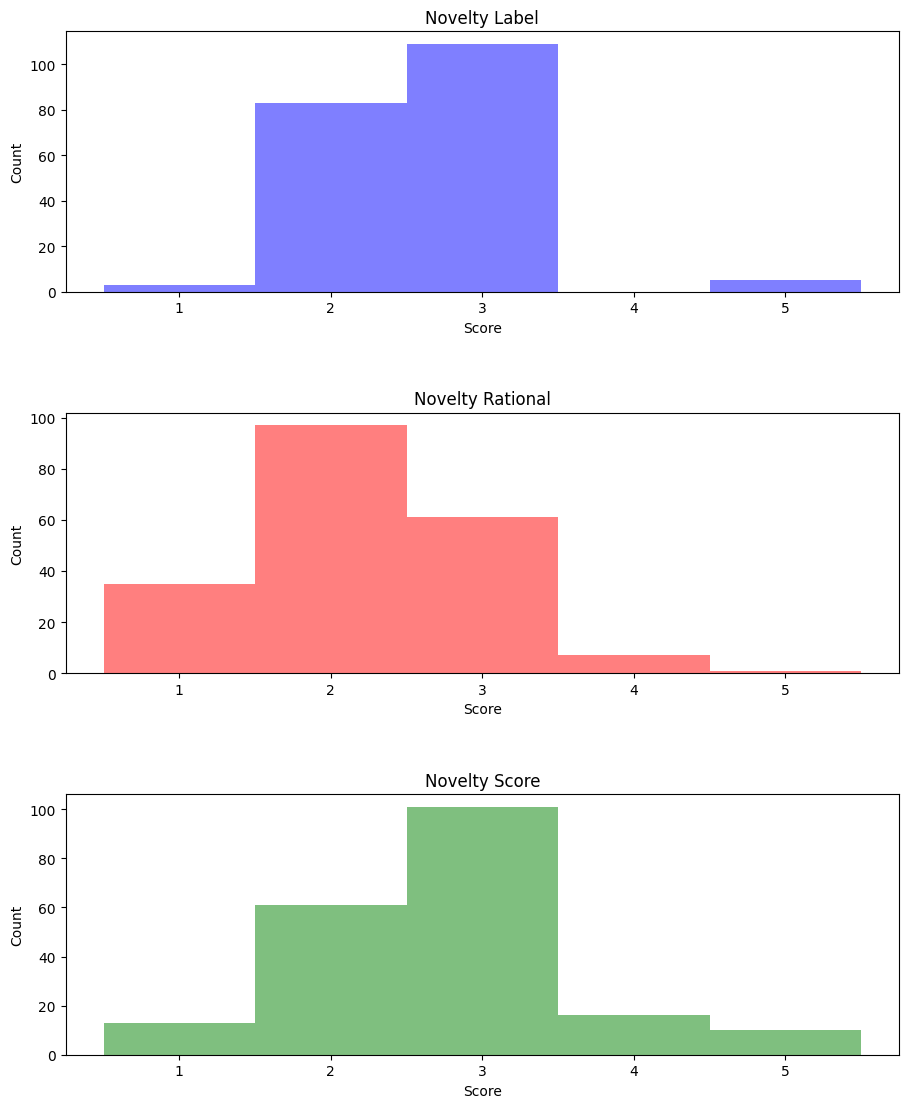

In [367]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10,12))

# Creating histogram for results_novelty_label
axs[0].hist(results_novelty_label['score'], bins = range(1,7), align='left', color='blue', alpha=0.5)
axs[0].set_title('Novelty Label')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Count')

# Creating histogram for results_novelty_rational
axs[1].hist(results_novelty_rational['score'], bins = range(1,7), align='left', color='red', alpha=0.5)
axs[1].set_title('Novelty Rational')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Count')

# Creating histogram for results_novelty_score
axs[2].hist(results_novelty_score['score'], bins = range(1,7), align='left', color='green', alpha=0.5)
axs[2].set_title('Novelty Score')
axs[2].set_xlabel('Score')
axs[2].set_ylabel('Count')

# Adding some space between subplots
plt.tight_layout(pad=4.0)

# Displaying the plot
plt.show()


In [368]:
# Define the names of the DataFrames and labels for plotting
dataframes = [results_novelty_label, results_novelty_rational, results_novelty_score, results_novelty_no_key_elements]
names = ["Novelty Label", "Novelty Rational", "Novelty Score", "Novelty No Key Elements"]
colors = ["blue", "red", "green", "purple"]

# Add labels to each DataFrame
for df in dataframes:
    df['label'] = sublist_labels.values


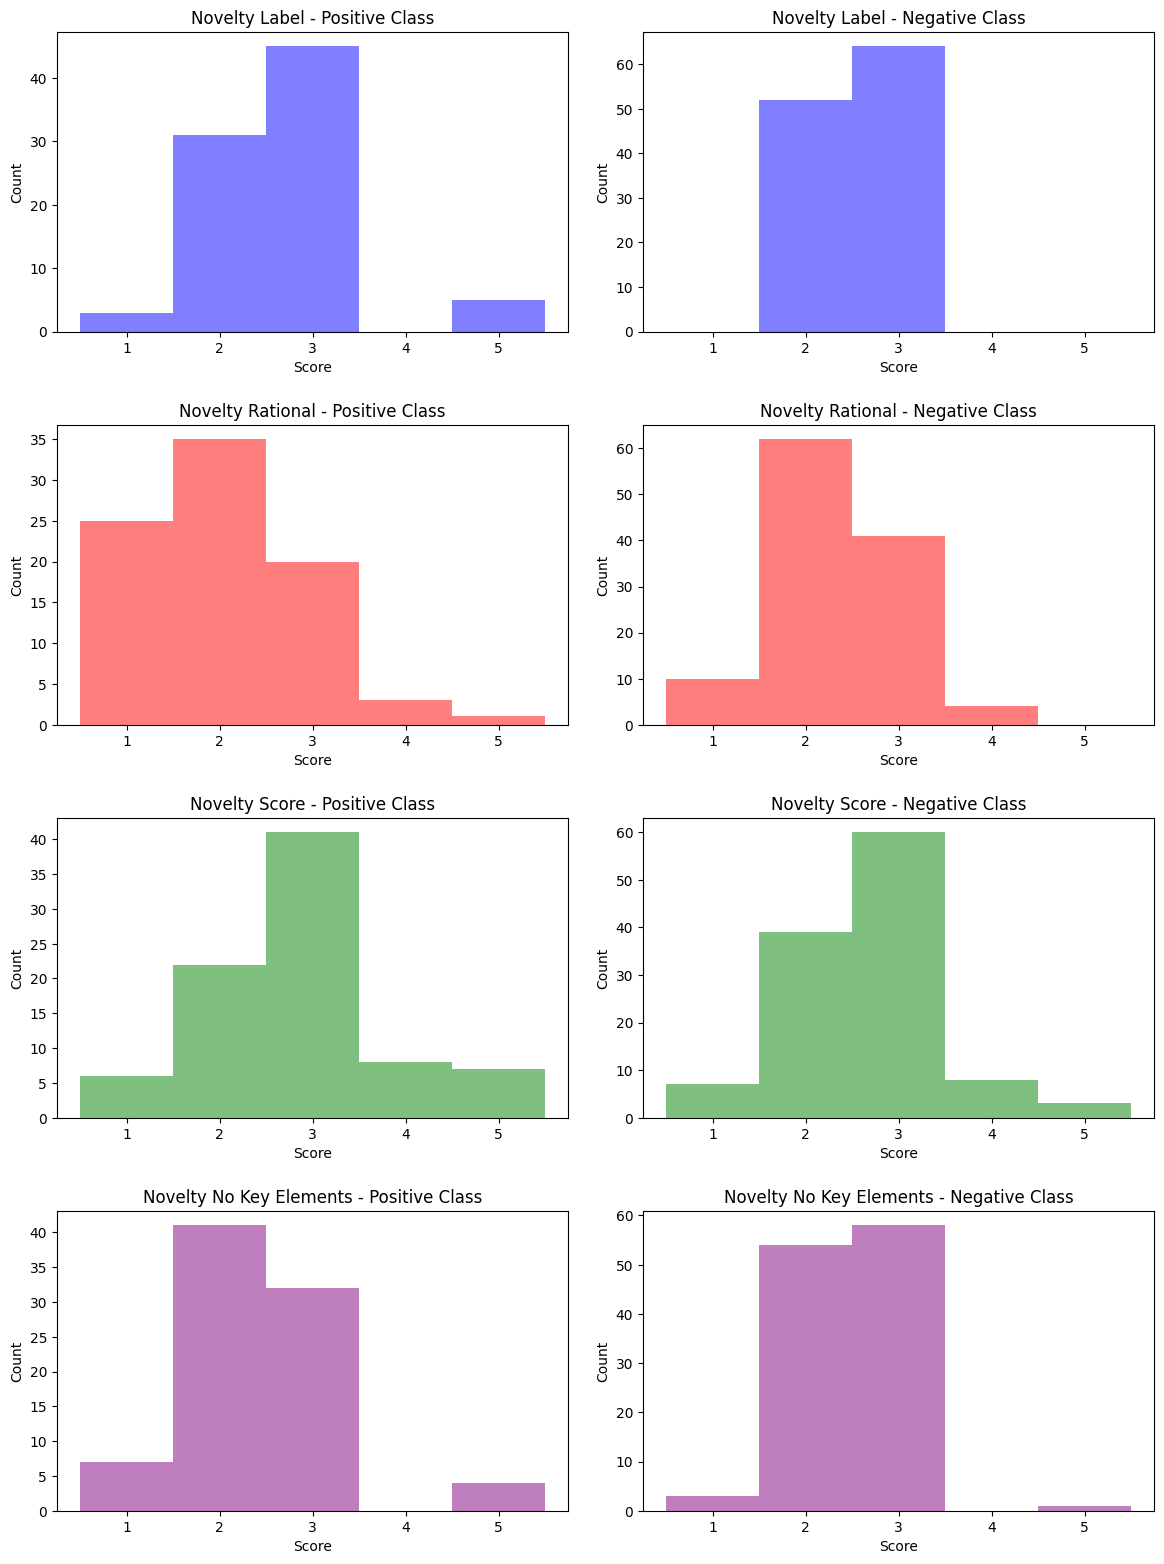

In [369]:
import matplotlib.pyplot as plt

# Calculate the number of rows needed for the subplots
n_rows = len(dataframes)
n_cols = 2  # We want 2 columns of subplots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))  # Adjust the figure size as needed

for i, (df, name, color) in enumerate(zip(dataframes, names, colors)):
    # Split the data into positive and negative classes
    positive_df = df[df['label'] == 1]
    negative_df = df[df['label'] == -1]

    # Create histogram for positive class
    axs[i, 0].hist(positive_df['score'], bins=range(1, 7), align='left', color=color, alpha=0.5)
    axs[i, 0].set_title(f'{name} - Positive Class')
    axs[i, 0].set_xlabel('Score')
    axs[i, 0].set_ylabel('Count')

    # Create histogram for negative class
    axs[i, 1].hist(negative_df['score'], bins=range(1, 7), align='left', color=color, alpha=0.5)
    axs[i, 1].set_title(f'{name} - Negative Class')
    axs[i, 1].set_xlabel('Score')
    axs[i, 1].set_ylabel('Count')

# Adding some space between subplots
plt.tight_layout(pad=2.0)

# Displaying the plot
plt.show()


#### Encoding

In [259]:
from tqdm import tqdm


score_list = []  # Initialize list to store score data

for i, tweet in tqdm(enumerate(feature_df['preprocessed']), total=len(feature_df)): 
    if i >= 500:
        break

    # API setup and call as before
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {OPENAI_API_KEY}"
    }

    content = system_prompt + "Given this tweet: " + tweet + key_elements + task_description_label

    data = {
        "model": "gpt-3.5-turbo",
        "messages": [{"role": "user", "content": f"{content}"}],
        "max_tokens": 512,
        "temperature": 0.1
    }


    try: 
        response = requests.post('https://api.openai.com/v1/chat/completions', headers=headers, data=json.dumps(data))
        answer = response.json()['choices'][0]['message']['content']
        score_list.append(answer)  # Append score to list
        print(response.json())
    except requests.exceptions.Timeout:
        print("The request timed out.")
    except KeyError:
        print("There was an error with the API call.")
        print("Full response:")
        print(response.json())
        score_list.append(np.nan)  # Append NaN for failed API calls
    except json.JSONDecodeError:
        print("Couldn't decode the response as JSON")
        score_list.append(np.nan)  # Append NaN for decoding errors

# Once all the scores are gathered, add them to the DataFrame as a new column
# feature_df['score'] = score_list
feature_df['score'] = pd.Series(score_list)

# Define mapping dictionary
label_mapping = {
    "Very novel.": 5,
    "novel.": 4,
    "Moderately novel.": 3,
    "Slightly novel.": 2,
    "Not novel at all.": 1
}

# Suppose df is your DataFrame and 'labels' is the column that contains the labels

feature_df['score'] = feature_df['score'].map(label_mapping)
    


,favourites,retweets,followers,source,label,preprocessed,length_preprocessed,sentiment_BERT,sentiment_RoBERTa,score
0,50.0,20.0,691748.0,official,-1,The drive-through coronavirus testing site in ...,157,4,1,3.0
1,58.0,25.0,12269236.0,official,-1,"""4⃣ and WHO are exploring how the EIB could s...",224,5,1,3.0
2,555.0,236.0,12269233.0,official,-1,Media briefing on COVID19 with,32,4,1,3.0
3,0.0,3251.0,512848.0,official,-1,"RT : The new NHSCOVID19app, now available in E...",125,5,1,3.0
4,NaN,NaN,NaN,competition,1,Dr. Yan presented evidence Covid 19...,190,1,1,3.0
...,...,...,...,...,...,...,...,...,...,...
28604,1.0,0.0,2509.0,truth_seeker,1,Omicron is genetically distant enough from i...,290,4,1,NaN
28605,123.0,15.0,691756.0,official,-1,UPDATE on COVIDー19 testing in the UK:\n\nToday...,203,2,1,NaN
28606,39.0,33.0,691757.0,official,-1,The pandemic is affecting us all. \n\nIf you a...,244,5,1,NaN
28607,129.0,51.0,12269355.0,official,-1,The interim guideline on the use of dexamethas...,168,4,1,NaN
